## Лабораторная работа 5.
### Выделение признаков символов

ФИО: Монастырный Максим Александрович

Группа: Б24-501 

**Импорт библиотек и константы**

In [1]:
from dataclasses import asdict, dataclass
from pathlib import Path

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageDraw, ImageFont

In [2]:
GREEK_LOWER = list("αβγδεζηθικλμνξοπρστυφχψω")

# Такие из коробки есть в Ubuntu
FONT_NAMES = [
    "DejaVu Sans",
    "Liberation Serif",
    "Liberation Sans",
    "Liberation Mono",
]
SIZES_PT = [10, 11, 12, 14, 16]

OUT_DIR = Path("../data/font")
IMG_DIR = OUT_DIR / "images"
PROFILE_DIR = OUT_DIR / "profiles"

FEATURES_CSV_PATH = OUT_DIR / "features.csv"

PROFILES_LONG_CSV_PATH = OUT_DIR / "profiles_long.csv"
PROFILES_WIDE_X_CSV_PATH = OUT_DIR / "profiles_x_wide.csv"
PROFILES_WIDE_Y_CSV_PATH = OUT_DIR / "profiles_y_wide.csv"

REPORT_BY_SYMBOL_CSV_PATH = OUT_DIR / "report_by_symbol.csv"
REPORT_BY_SYMBOL_FONT_CSV_PATH = OUT_DIR / "report_by_symbol_font.csv"

CANVAS_PAD = 30
CROP_PAD = 2
THRESHOLD = 128

In [3]:
OUT_DIR.mkdir(parents=True, exist_ok=True)
IMG_DIR.mkdir(parents=True, exist_ok=True)
PROFILE_DIR.mkdir(parents=True, exist_ok=True)

**Вспомогательные функции**

In [4]:
def load_font(font_name: str, size_pt: int) -> tuple[ImageFont.ImageFont, str]:
    """Load a TrueType/OpenType font by name with fallback.

    Args:
        font_name: Requested font family name.
        size_pt: Font size in points.

    Returns:
        (font_object, resolved_font_label)
    """
    path = fm.findfont(font_name, fallback_to_default=False)
    return ImageFont.truetype(path, size_pt), font_name


def sanitize_font_tag(font_label: str) -> str:
    """Sanitize font label for filenames."""
    return font_label.replace(" ", "_").replace("/", "_")


def save_csv(
    path: Path,
    header: list[str],
    rows: np.ndarray,
    fmt: list[str],
    delimiter: str = ",",
) -> None:
    """Write a CSV file using NumPy only (no csv module).

    Args:
        path: Output file path.
        header: Column names.
        rows: 2D array of values (strings not supported by np.savetxt well).
        fmt: Format strings for each column (e.g., '%s', '%.8f', '%d').
        delimiter: Field delimiter (default ',').
    """
    path.parent.mkdir(parents=True, exist_ok=True)
    header_line = delimiter.join(header)

    np.savetxt(
        path,
        rows,
        fmt=fmt,
        delimiter=delimiter,
        header=header_line,
        comments="",
    )

Загрузка шрифтов, рендеринг символов

In [5]:
def render_symbol(
    ch: str,
    font: ImageFont.FreeTypeFont,
    padding: int = CROP_PAD,
    canvas_pad: int = CANVAS_PAD,
) -> Image.Image:
    """Render a single character to a tightly-cropped grayscale image."""
    if len(ch) != 1:
        raise ValueError("render_symbol expects a single character.")

    # Measure
    dummy = Image.new("L", (1, 1), color=255)
    draw = ImageDraw.Draw(dummy)
    bbox = draw.textbbox((0, 0), ch, font=font)
    w = max(1, bbox[2] - bbox[0])
    h = max(1, bbox[3] - bbox[1])

    canvas = Image.new("L", (w + 2 * canvas_pad, h + 2 * canvas_pad), color=255)
    draw = ImageDraw.Draw(canvas)
    draw.text((canvas_pad - bbox[0], canvas_pad - bbox[1]), ch, fill=0, font=font)

    arr = np.array(canvas, dtype=np.uint8)
    mask = arr < 250
    if not np.any(mask):
        return canvas

    ys, xs = np.where(mask)
    y0, y1 = int(ys.min()), int(ys.max())
    x0, x1 = int(xs.min()), int(xs.max())

    y0 = max(0, y0 - padding)
    x0 = max(0, x0 - padding)
    y1 = min(arr.shape[0] - 1, y1 + padding)
    x1 = min(arr.shape[1] - 1, x1 + padding)

    return canvas.crop((x0, y0, x1 + 1, y1 + 1))

In [6]:
def save_profile_plot(
    values: np.ndarray, title: str, xlabel: str, ylabel: str, out_path: Path
) -> None:
    """Save a bar chart (PNG) for a 1D profile array."""
    n = int(values.shape[0])
    x = np.arange(n, dtype=np.int32)

    plt.figure()
    plt.bar(x, values)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    if n <= 40:
        plt.xticks(x)
    else:
        step = max(1, n // 20)
        plt.xticks(x[::step])

    ymax = int(values.max()) if n > 0 else 1
    yt_step = max(1, ymax // 10) if ymax > 0 else 1
    plt.yticks(np.arange(0, ymax + 1, yt_step))

    plt.tight_layout()
    plt.savefig(str(out_path), dpi=200)
    plt.close()

Расчет необходимых признаков

In [7]:
@dataclass(frozen=True)
class Features:
    """Scalar feature set for a single symbol image."""

    symbol: str
    codepoint: str
    font: str
    size_pt: int
    width: int
    height: int

    mass_total: int

    q1_mass: int
    q2_mass: int
    q3_mass: int
    q4_mass: int

    q1_density: float
    q2_density: float
    q3_density: float
    q4_density: float

    cx: float
    cy: float
    cx_norm: float
    cy_norm: float

    ix: float
    iy: float
    ix_norm: float
    iy_norm: float

In [8]:
def quarter_masses(black: np.ndarray) -> tuple[int, int, int, int]:
    """Compute black pixel mass in four quadrants."""
    h, w = black.shape
    h2, w2 = h // 2, w // 2
    q1 = int(black[:h2, :w2].sum())  # top-left
    q2 = int(black[:h2, w2:].sum())  # top-right
    q3 = int(black[h2:, :w2].sum())  # bottom-left
    q4 = int(black[h2:, w2:].sum())  # bottom-right
    return q1, q2, q3, q4


def centroid(black: np.ndarray) -> tuple[float, float]:
    """Compute centroid (center of mass) of black pixels."""
    h, w = black.shape
    mass = int(black.sum())
    if mass == 0:
        return (w - 1) / 2.0, (h - 1) / 2.0

    ys, xs = np.where(black > 0)
    return float(xs.mean()), float(ys.mean())


def axial_moments(black: np.ndarray, cx: float, cy: float) -> tuple[float, float]:
    """Compute axial second central moments Ix and Iy."""
    mass = int(black.sum())
    if mass == 0:
        return 0.0, 0.0

    ys, xs = np.where(black > 0)
    dy2 = (ys.astype(np.float64) - cy) ** 2
    dx2 = (xs.astype(np.float64) - cx) ** 2
    ix = float(dy2.sum())
    iy = float(dx2.sum())
    return ix, iy


def normalize_moments(
    ix: float, iy: float, mass: int, w: int, h: int
) -> tuple[float, float]:
    """Normalize moments to unit-less values."""
    if mass <= 0:
        return 0.0, 0.0
    denom_ix = float(mass) * float(h**2)
    denom_iy = float(mass) * float(w**2)
    return (
        ix / denom_ix if denom_ix > 0 else 0.0,
        iy / denom_iy if denom_iy > 0 else 0.0,
    )


def compute_features(
    symbol: str,
    font_label: str,
    size_pt: int,
    img: Image.Image,
) -> tuple[Features, np.ndarray, np.ndarray, np.ndarray]:
    """Compute scalar features and X/Y profiles.

    Args:
        symbol: Symbol character.
        font_label: Resolved font label.
        size_pt: Font size in points.
        img: Cropped grayscale image.

    Returns:
        (features, black_mask, x_profile, y_profile)
    """
    # binarize
    arr = np.array(img, dtype=np.uint8)
    black = (arr < THRESHOLD).astype(np.uint8)

    h, w = black.shape
    mass = int(black.sum())

    q1, q2, q3, q4 = quarter_masses(black)

    h2, w2 = h // 2, w // 2
    a1 = max(1, h2 * w2)
    a2 = max(1, h2 * (w - w2))
    a3 = max(1, (h - h2) * w2)
    a4 = max(1, (h - h2) * (w - w2))
    d1, d2, d3, d4 = q1 / a1, q2 / a2, q3 / a3, q4 / a4

    cx, cy = centroid(black)
    cx_norm = cx / (w - 1) if w > 1 else 0.0
    cy_norm = cy / (h - 1) if h > 1 else 0.0

    ix, iy = axial_moments(black, cx, cy)
    ix_norm, iy_norm = normalize_moments(ix, iy, mass, w, h)

    x_profile = black.sum(axis=0).astype(np.int32)
    y_profile = black.sum(axis=1).astype(np.int32)

    feat = Features(
        symbol,
        f"U+{ord(symbol):04X}",
        font_label,
        size_pt,
        w,
        h,
        mass,
        q1,
        q2,
        q3,
        q4,
        d1,
        d2,
        d3,
        d4,
        cx,
        cy,
        cx_norm,
        cy_norm,
        ix,
        iy,
        ix_norm,
        iy_norm,
    )
    return feat, black, x_profile, y_profile

Запуск обработки всех шрифтов и символов

In [9]:
def run_all() -> (
    tuple[list[dict[str, object]], list[tuple[str, str, str, int, str, int, int]]]
):
    """Generate images, compute features, save plots, store profiles.

    Returns:
        features_rows: list of dicts (scalar features + file paths).
        profiles_long: list of tuples (base_id, symbol, codepoint, size_pt, axis, index, value).
                      Font is stored separately in base_id; we also store font explicitly in reports later.
    """

    features_rows: list[dict[str, object]] = []
    profiles_long: list[tuple[str, str, str, str, int, str, int, int]] = []
    # tuple: (base_id, symbol, codepoint, font, size_pt, axis, index, value)

    for font_name in FONT_NAMES:
        for size_pt in SIZES_PT:
            font_obj, resolved_label = load_font(font_name, size_pt)
            print(f"Processing font '{resolved_label}' {size_pt}pt")

            for symbol in GREEK_LOWER:
                img = render_symbol(symbol, font_obj)

                feat, _, x_prof, y_prof = compute_features(
                    symbol, resolved_label, size_pt, img
                )

                base_path = (
                    resolved_label.replace(" ", "_").replace("/", "_")
                    + f"_{int(size_pt)}"
                )
                (IMG_DIR / Path(base_path)).mkdir(parents=True, exist_ok=True)
                (PROFILE_DIR / Path(base_path)).mkdir(parents=True, exist_ok=True)

                base_path += f"/{ord(symbol):04X}"

                img_path = IMG_DIR / f"{base_path}.png"
                img.save(img_path)

                x_png = PROFILE_DIR / f"{base_path}_X.png"
                y_png = PROFILE_DIR / f"{base_path}_Y.png"

                save_profile_plot(
                    x_prof,
                    title=f"X-profile {feat.symbol} ({feat.codepoint}) | {feat.font} {feat.size_pt}pt",
                    xlabel="x (column index)",
                    ylabel="black pixels",
                    out_path=x_png,
                )
                save_profile_plot(
                    y_prof,
                    title=f"Y-profile {feat.symbol} ({feat.codepoint}) | {feat.font} {feat.size_pt}pt",
                    xlabel="y (row index from top)",
                    ylabel="black pixels",
                    out_path=y_png,
                )

                row = asdict(feat)
                row["base_id"] = base_path
                row["image_path"] = str(img_path)
                row["x_profile_png"] = str(x_png)
                row["y_profile_png"] = str(y_png)
                features_rows.append(row)

                # Long-format profile tuples
                for i in range(int(x_prof.shape[0])):
                    profiles_long.append(
                        (
                            base_path,
                            feat.symbol,
                            feat.codepoint,
                            feat.font,
                            int(feat.size_pt),
                            "X",
                            int(i),
                            int(x_prof[i]),
                        )
                    )
                for i in range(int(y_prof.shape[0])):
                    profiles_long.append(
                        (
                            base_path,
                            feat.symbol,
                            feat.codepoint,
                            feat.font,
                            int(feat.size_pt),
                            "Y",
                            int(i),
                            int(y_prof[i]),
                        )
                    )

    return features_rows, profiles_long

In [10]:
features_rows, profiles_long = run_all()

len(features_rows), len(profiles_long)

Processing font 'DejaVu Sans' 10pt
Processing font 'DejaVu Sans' 11pt
Processing font 'DejaVu Sans' 12pt
Processing font 'DejaVu Sans' 14pt
Processing font 'DejaVu Sans' 16pt
Processing font 'Liberation Serif' 10pt
Processing font 'Liberation Serif' 11pt
Processing font 'Liberation Serif' 12pt
Processing font 'Liberation Serif' 14pt
Processing font 'Liberation Serif' 16pt
Processing font 'Liberation Sans' 10pt
Processing font 'Liberation Sans' 11pt
Processing font 'Liberation Sans' 12pt
Processing font 'Liberation Sans' 14pt
Processing font 'Liberation Sans' 16pt
Processing font 'Liberation Mono' 10pt
Processing font 'Liberation Mono' 11pt
Processing font 'Liberation Mono' 12pt
Processing font 'Liberation Mono' 14pt
Processing font 'Liberation Mono' 16pt


(480, 11153)

Сохранение признаков и диаграмм

In [11]:
features_header = [
    "symbol",
    "codepoint",
    "font",
    "size_pt",
    "width",
    "height",
    "mass_total",
    "q1_mass",
    "q2_mass",
    "q3_mass",
    "q4_mass",
    "q1_density",
    "q2_density",
    "q3_density",
    "q4_density",
    "cx",
    "cy",
    "cx_norm",
    "cy_norm",
    "ix",
    "iy",
    "ix_norm",
    "iy_norm",
    "base_id",
    "image_path",
    "x_profile_png",
    "y_profile_png",
]

features_fmt = [
    "%s",
    "%s",
    "%s",
    "%d",
    "%d",
    "%d",
    "%d",
    "%d",
    "%d",
    "%d",
    "%d",
    "%.8f",
    "%.8f",
    "%.8f",
    "%.8f",
    "%.8f",
    "%.8f",
    "%.8f",
    "%.8f",
    "%.8f",
    "%.8f",
    "%.8f",
    "%.8f",
    "%s",
    "%s",
    "%s",
    "%s",
]

In [12]:
features_matrix = np.empty((len(features_rows), len(features_header)), dtype=object)
for r_idx, row in enumerate(features_rows):
    for c_idx, key in enumerate(features_header):
        features_matrix[r_idx, c_idx] = row[key]

save_csv(FEATURES_CSV_PATH, features_header, features_matrix, features_fmt)

In [13]:
profiles_header = [
    "base_id",
    "symbol",
    "codepoint",
    "font",
    "size_pt",
    "axis",
    "index",
    "value",
]
profiles_fmt = ["%s", "%s", "%s", "%s", "%d", "%s", "%d", "%d"]

In [14]:
profiles_matrix = np.empty((len(profiles_long), len(profiles_header)), dtype=object)
for i, t in enumerate(profiles_long):
    profiles_matrix[i, :] = list(t)

save_csv(
    PROFILES_LONG_CSV_PATH,
    profiles_header,
    profiles_matrix,
    profiles_fmt,
)

In [15]:
def save_profiles_wide(
    profiles_long: list[tuple[str, str, str, str, int, str, int, int]],
) -> None:
    """Save X and Y profiles in wide format with padding.

    Args:
        profiles_long: Long-format profile tuples.
    """
    groups: dict[tuple[str, str], dict[str, object]] = {}

    for base_id, symbol, codepoint, font, size_pt, axis, idx, val in profiles_long:
        key = (base_id, axis)
        if key not in groups:
            groups[key] = {
                "base_id": base_id,
                "symbol": symbol,
                "codepoint": codepoint,
                "font": font,
                "size_pt": int(size_pt),
                "values": {},
            }
        groups[key]["values"][int(idx)] = int(val)

    x_items = [g for (bid, ax), g in groups.items() if ax == "X"]
    y_items = [g for (bid, ax), g in groups.items() if ax == "Y"]

    def write_axis(items: list[dict[str, object]], out_path: Path) -> None:
        if not items:
            return

        max_len = 0
        for it in items:
            if it["values"]:
                max_len = max(max_len, max(it["values"].keys()) + 1)

        header = ["base_id", "symbol", "codepoint", "font", "size_pt"] + [
            f"p{i}" for i in range(max_len)
        ]
        fmt = ["%s", "%s", "%s", "%s", "%d"] + ["%d"] * max_len

        mat = np.empty((len(items), len(header)), dtype=object)

        for r, it in enumerate(items):
            mat[r, 0] = it["base_id"]
            mat[r, 1] = it["symbol"]
            mat[r, 2] = it["codepoint"]
            mat[r, 3] = it["font"]
            mat[r, 4] = it["size_pt"]

            vals = np.full((max_len,), -1, dtype=np.int32)
            for k, v in it["values"].items():
                if 0 <= k < max_len:
                    vals[k] = v
            for j in range(max_len):
                mat[r, 5 + j] = int(vals[j])

        save_csv(out_path, header, mat, fmt)

    write_axis(x_items, PROFILES_WIDE_X_CSV_PATH)
    write_axis(y_items, PROFILES_WIDE_Y_CSV_PATH)

In [16]:
save_profiles_wide(profiles_long)

In [17]:
def rows_to_arrays(features_rows: list[dict[str, object]]) -> dict[str, np.ndarray]:
    """Convert list-of-dicts to column arrays (NumPy-friendly).

    Args:
        features_rows: Feature rows as dictionaries.

    Returns:
        dictionary of columns. String columns are dtype=object.
    """
    cols = {k: [] for k in features_rows[0].keys()}
    for r in features_rows:
        for k, v in r.items():
            cols[k].append(v)

    out: dict[str, np.ndarray] = {}
    for k, lst in cols.items():
        # decide numeric vs object
        if isinstance(lst[0], (int, float, np.integer, np.floating)):
            out[k] = np.array(lst, dtype=np.float64)
        else:
            out[k] = np.array(lst, dtype=object)
    return out


def aggregate_group(
    key_cols: list[np.ndarray],
    metrics: dict[str, np.ndarray],
) -> tuple[np.ndarray, list[str], np.ndarray, list[str], list[list[str]]]:
    """Aggregate metrics by group keys (NumPy-only group-by).

    Args:
        key_cols: Arrays for grouping (dtype object).
        metrics: dict metric_name -> float64 array.

    Returns:
        keys_matrix: 2D object array of group keys.
        key_names: Key column names (provided externally).
        agg_matrix: 2D float array with columns for each metric/stat.
        agg_colnames: Names like '{metric}_mean', '{metric}_std', ...
        fmts: Per-column formats for final CSV (keys + metrics).
    """
    # Create combined keys as tuples.
    n = key_cols[0].shape[0]
    keys = np.empty((n,), dtype=object)
    for i in range(n):
        keys[i] = tuple(col[i] for col in key_cols)

    uniq_keys, inv = np.unique(keys, return_inverse=True)

    metric_names = list(metrics.keys())
    stats = ["mean", "std", "min", "max"]
    agg_colnames = [f"{m}_{s}" for m in metric_names for s in stats]

    agg_matrix = np.zeros((uniq_keys.shape[0], len(agg_colnames)), dtype=np.float64)

    for g in range(uniq_keys.shape[0]):
        idx = np.where(inv == g)[0]
        c = 0
        for m in metric_names:
            v = metrics[m][idx]
            agg_matrix[g, c + 0] = float(np.mean(v))
            agg_matrix[g, c + 1] = float(np.std(v))
            agg_matrix[g, c + 2] = float(np.min(v))
            agg_matrix[g, c + 3] = float(np.max(v))
            c += 4

    # keys_matrix as 2D object array
    kdim = len(uniq_keys[0]) if uniq_keys.shape[0] > 0 else len(key_cols)
    keys_matrix = np.empty((uniq_keys.shape[0], kdim), dtype=object)
    for i, k in enumerate(uniq_keys):
        for j in range(kdim):
            keys_matrix[i, j] = k[j]

    return keys_matrix, agg_matrix, agg_colnames


def save_report_tables(features_rows: list[dict[str, object]]) -> None:
    """Create and save report tables (by symbol; by symbol+font)."""
    cols = rows_to_arrays(features_rows)

    metric_names = [
        "mass_total",
        "q1_mass",
        "q2_mass",
        "q3_mass",
        "q4_mass",
        "q1_density",
        "q2_density",
        "q3_density",
        "q4_density",
        "cx",
        "cy",
        "cx_norm",
        "cy_norm",
        "ix",
        "iy",
        "ix_norm",
        "iy_norm",
        "width",
        "height",
    ]
    metrics = {m: cols[m].astype(np.float64) for m in metric_names}

    # Report 1: by symbol
    key_names_1 = ["symbol", "codepoint"]
    key_cols_1 = [cols["symbol"], cols["codepoint"]]
    keys1, agg1, aggcols = aggregate_group(key_cols_1, metrics)

    header1 = key_names_1 + aggcols
    fmt1 = ["%s", "%s"] + ["%.8f"] * agg1.shape[1]
    mat1 = np.empty((keys1.shape[0], keys1.shape[1] + agg1.shape[1]), dtype=object)
    mat1[:, : keys1.shape[1]] = keys1
    mat1[:, keys1.shape[1] :] = agg1
    save_csv(REPORT_BY_SYMBOL_CSV_PATH, header1, mat1, fmt1)

    # Report 2: by symbol + font
    key_names_2 = ["symbol", "codepoint", "font"]
    key_cols_2 = [cols["symbol"], cols["codepoint"], cols["font"]]
    keys2, agg2, aggcols2 = aggregate_group(key_cols_2, metrics)

    header2 = key_names_2 + aggcols2
    fmt2 = ["%s", "%s", "%s"] + ["%.8f"] * agg2.shape[1]
    mat2 = np.empty((keys2.shape[0], keys2.shape[1] + agg2.shape[1]), dtype=object)
    mat2[:, : keys2.shape[1]] = keys2
    mat2[:, keys2.shape[1] :] = agg2
    save_csv(REPORT_BY_SYMBOL_FONT_CSV_PATH, header2, mat2, fmt2)

In [18]:
save_report_tables(features_rows)

Визуализация результата

In [19]:
# Info

GREEK_LOWER = list("αβγδεζηθικλμνξοπρστυφχψω")

# Такие из коробки есть в Ubuntu
FONT_NAMES = [
    "DejaVu Sans",
    "Liberation Serif",
    "Liberation Sans",
    "Liberation Mono",
]
SIZES_PT = [10, 11, 12, 14, 16]

In [20]:
font = "DejaVu_Sans"
font_size = 16
symbol = "α"

In [21]:
# Символ
Image.open(IMG_DIR / f"{font}_{font_size}/{ord(symbol):04X}.png")

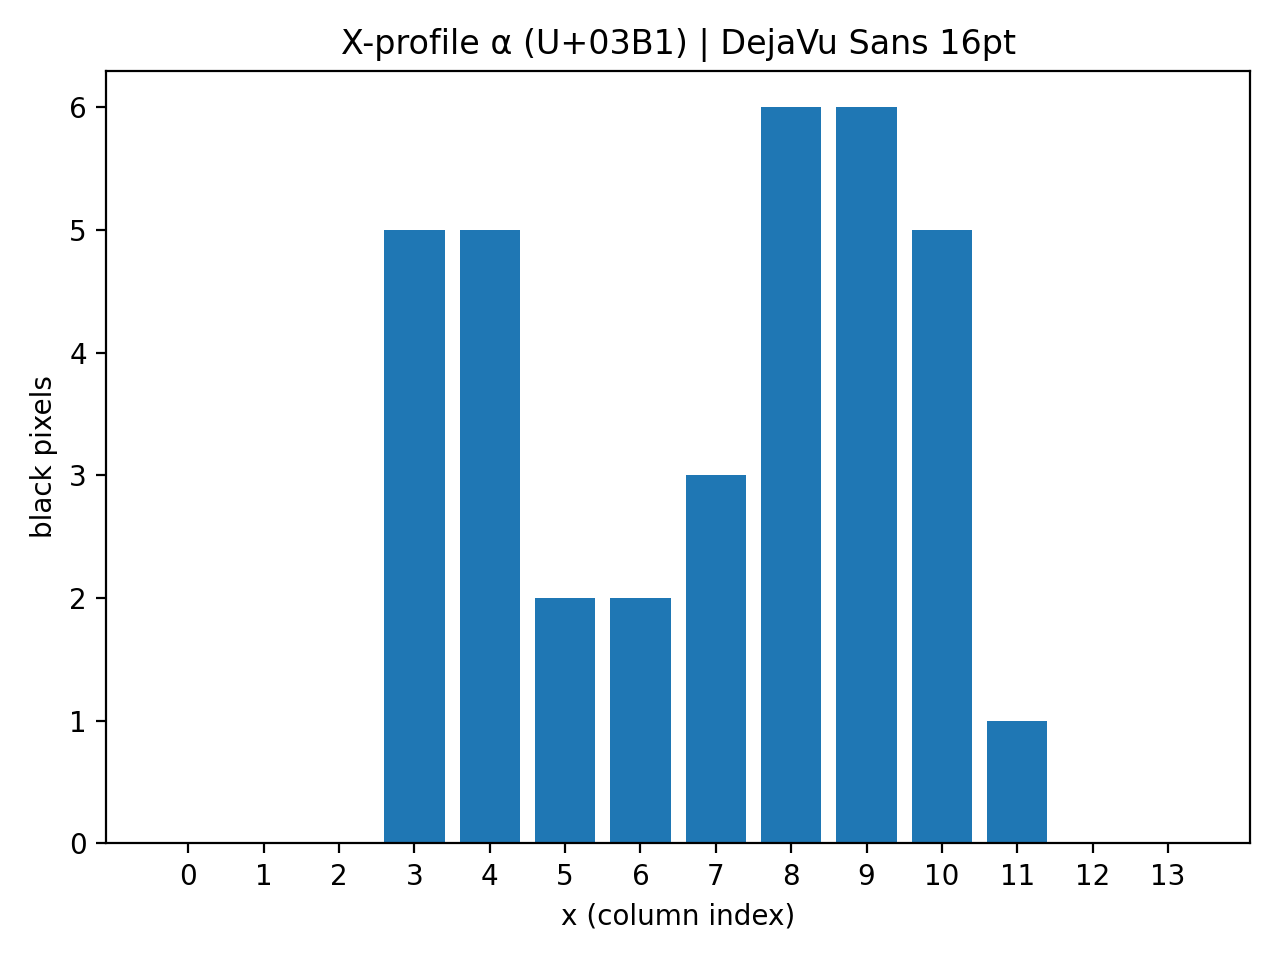

In [22]:
# Графики профилей
Image.open(PROFILE_DIR / f"{font}_{font_size}/{ord(symbol):04X}_X.png")

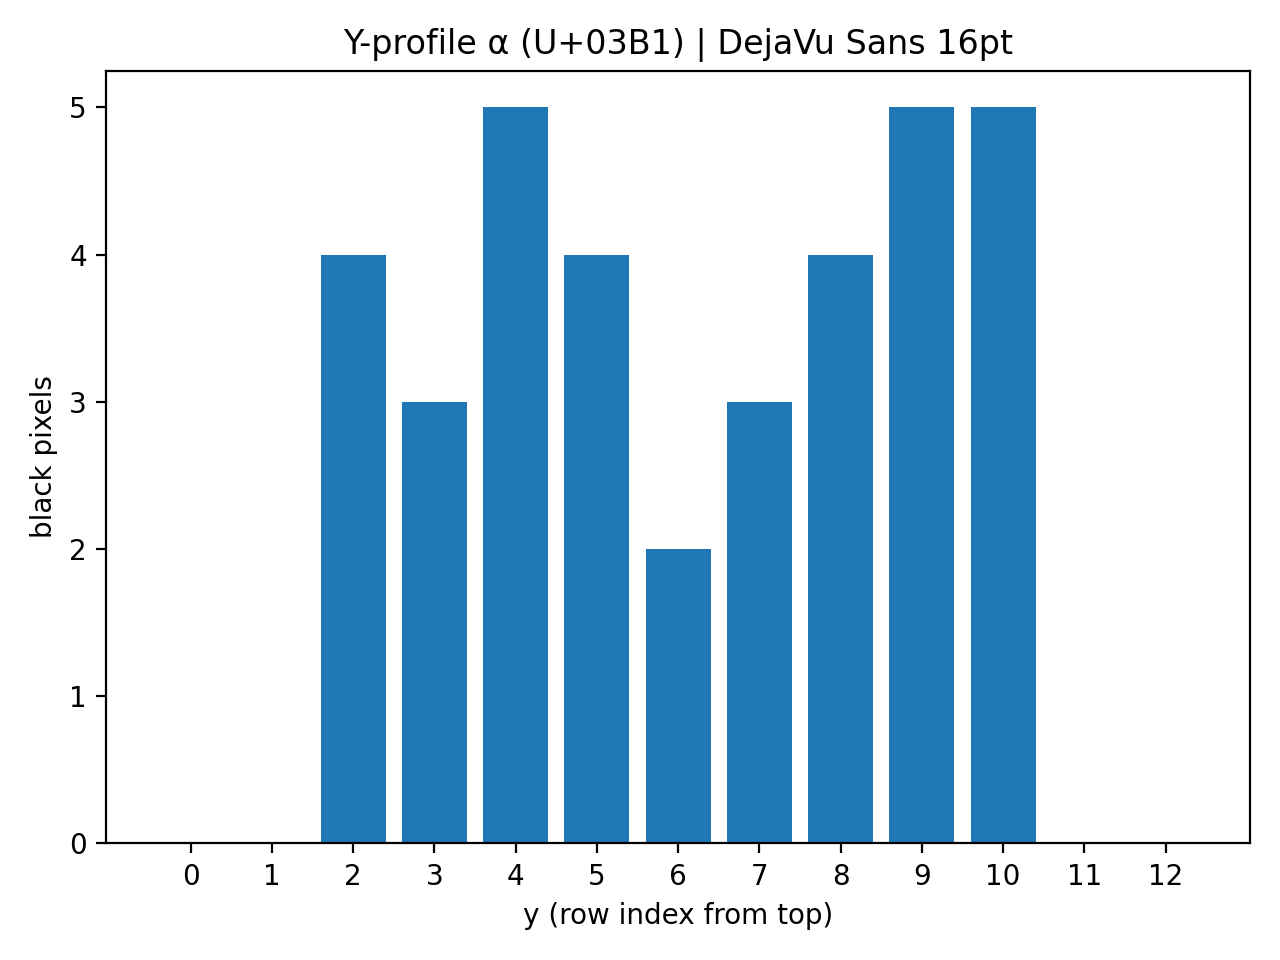

In [23]:
Image.open(PROFILE_DIR / f"{font}_{font_size}/{ord(symbol):04X}_Y.png")